# Credit Card Fraud Detection

Il dataset contiene transazioni fatte tramite carta di credito nel settembre 2013 in Europa.
Questo dataset presenta transazioni avvenute in due giorni. Delle 284807 transazioni, 492 sono etichettate come frodi, le altre sono da ritenersi legittime. Il dataset è estremamente sbilanciato, con i casi positivi che rappresentano soltanto lo 0.172% di tutte le transazioni.

Nel dataset sono presenti soltanto variabili di input di tipo numerico, risultanti da una trasformazione Principal Component Analysis (PCA). Per ragioni di confidenzialità non sono disponibili né le features originali né informazioni sull'origine dei dati più dettagliate. Le uniche features non trasformate tramite PCA sono 'Tempo' e 'Ammontare'.
Il tempo misura i sencondi trascorsi tra ogni transazione e la prima transazione del dataset. La feature 'Ammontare' è l'ammontare della transazione.
Le transazioni etichettate con 1 sono frodi, quelle etichettate con 0 sono legittime.

Essendo il dataset già curato non sono necessarie operazioni di pulizia ed imputazione dei dati.



## Setup dell'ambiente

Le operazioni di setup sono differenti a seconda della piattaforma utilizzata, ne va utilizzato solo uno, o del codice personalizzato in caso di ambienti diversi.

In [ ]:
# Kaggle token
token = {"username":"-","key":"-"}

### Google Colaboratory

In [ ]:
filepath = "/content/creditfraud/creditcard.csv"

! rm -Rf /content/creditfraud/
! which kaggle || pip install kaggle
! if ! [ -d ~/.kaggle ] ; then  mkdir ~/.kaggle  && touch ~/.kaggle/kaggle.json; echo "Creating kaggle directory"; fi

import json

import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! if ! [ -f /content/creditfraud/creditcard.csv ] ; then chmod 600 /root/.kaggle/kaggle.json && kaggle datasets download -p /content/creditfraud/ -d mlg-ulb/creditcardfraud ; fi

os.chdir('/content/creditfraud')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

/usr/local/bin/kaggle
Creating kaggle directory
 96% 63.0M/66.0M [00:00<00:00, 59.3MB/s]
100% 66.0M/66.0M [00:00<00:00, 84.7MB/s]


In [ ]:
!head -n 2 /content/creditfraud/creditcard.csv
!tail -n 2 /content/creditfraud/creditcard.csv

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,"0"
172788,-0.240440049680947,0.530482513118839,0.702510230095103,0.689799168040973,-0.377961134444982,0.62370772214768,-0.68617998628885,0.679145459790659,0.392086712465972,-0.399125651432835,-1.93384881505713,-0.962886142890271,-1.04208165591191,0.449624443166001,1.96256312066577,-0.60857

In [ ]:
%%shell

apt-get install openjdk-8-jdk-headless -qq  &>/dev/null
if ! [ -f spark-3.1.1-bin-hadoop2.7.tgz ] ; then 
  wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz && 
  tar xf spark-3.1.1-bin-hadoop2.7.tgz ; 
fi
pip show findspark &>/dev/null || pip install -q findspark
pip show pyspark &>/dev/null || pip install pyspark

     |████████████████████████████████| 212.3MB 71kB/s 
     |████████████████████████████████| 204kB 49.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=774a25eeefca509a27a43ed6caf00466b41e8a5b97129b2b59dc399fe03c9cf2
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
# Set up required environment variables

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/creditfraud/spark-3.1.1-bin-hadoop2.7"

! mkdir -p $SPARK_HOME/conf/
! echo "spark.driver.memory              8g" >> $SPARK_HOME/conf/spark-defaults.conf

import findspark
location = findspark.find()
findspark.init(location)

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('CardFraud').getOrCreate()

### Kaggle notebook

È necessario abilitare internet per il notebook, è quindi richiesta la verifica tramite numero di telefono.

In [ ]:
filepath = "../input/creditcardfraud/creditcard.csv"

!head -n 2 ../input/creditcardfraud/creditcard.csv
!tail -n 2 ../input/creditcardfraud/creditcard.csv

In [ ]:
! apt-get install openjdk-8-jdk-headless -qq &>/dev/null
! if ! [ -f spark-3.1.1-bin-hadoop2.7.tgz ] ; then \
  wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz && \
  tar xf spark-3.1.1-bin-hadoop2.7.tgz ; \
fi
! pip show findspark &>/dev/null || pip install -q findspark
! pip show pyspark &>/dev/null || pip install pyspark

In [ ]:
# Set up required environment variables

# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "./spark-3.1.1-bin-hadoop2.7"


! mkdir -p $SPARK_HOME/conf/
! echo "spark.driver.memory              8g" >> $SPARK_HOME/conf/spark-defaults.conf

import findspark
location = findspark.find()
findspark.init(location)

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('CardFraud').getOrCreate()

### Databricks Community Edition

Con la versione community è necessario caricare manualmente il file .csv nel filesystem distribuito.

In [ ]:
filepath = "dbfs:/FileStore/creditcard.csv"
import mlflow

! rm -Rf /content/creditfraud/
! which kaggle || pip install kaggle
! if ! [ -d ~/.kaggle ] ; then  mkdir ~/.kaggle  && touch ~/.kaggle/kaggle.json; echo "Creating kaggle directory"; fi

import json

import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! if ! [ -f /content/creditfraud/creditcard.csv ] ; then chmod 600 /root/.kaggle/kaggle.json && kaggle datasets download -p /content/creditfraud/ -d mlg-ulb/creditcardfraud ; fi

os.chdir('/content/creditfraud')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [ ]:
!head -n 2 /content/creditfraud/creditcard.csv
!tail -n 2 /content/creditfraud/creditcard.csv

In [ ]:
# Set up required environment variables

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('CardFraud').getOrCreate()

## Analisi dei dati

In [ ]:
# Importazione dei dati dal data set 
from pyspark.sql.types import *
from pyspark.sql.functions import *


# costruzione dello schema del DataFrame

creditcard_schema = StructType([
    StructField('Time',IntegerType(),False),
    StructField('V1',FloatType(),False),
    StructField('V2',FloatType(),False),
    StructField('V3',FloatType(),False),
    StructField('V4',FloatType(),False),
    StructField('V5',FloatType(),False),
    StructField('V6',FloatType(),False),
    StructField('V7',FloatType(),False),
    StructField('V8',FloatType(),False),
    StructField('V9',FloatType(),False),
    StructField('V10',FloatType(),False),
    StructField('V11',FloatType(),False),
    StructField('V12',FloatType(),False),
    StructField('V13',FloatType(),False),
    StructField('V14',FloatType(),False),
    StructField('V15',FloatType(),False),
    StructField('V16',FloatType(),False),
    StructField('V17',FloatType(),False),
    StructField('V18',FloatType(),False),
    StructField('V19',FloatType(),False),
    StructField('V20',FloatType(),False),
    StructField('V21',FloatType(),False),
    StructField('V22',FloatType(),False),
    StructField('V23',FloatType(),False),
    StructField('V24',FloatType(),False),
    StructField('V25',FloatType(),False),
    StructField('V26',FloatType(),False),
    StructField('V27',FloatType(),False),
    StructField('V28',FloatType(),False),
    StructField('Amount',FloatType(),False),
    StructField('Class',ShortType(),False),
])

records = spark.read.format('csv')\
    .option('header','true')\
    .option('mode','DROPMALFORMED')\
    .option('mode','PERMISSIVE')\
    .schema(creditcard_schema)\
    .load(filepath)#.dropDuplicates()

#records.printSchema()
#records.show()

display(records)

# Checking null values

from pyspark.sql.functions import isnull

print("Null values:")
display(records.select([count(when(isnull(c), c)).alias(c) for c in records.columns]).toPandas())
#display(records.describe().toPandas())

DataFrame[Time: int, V1: float, V2: float, V3: float, V4: float, V5: float, V6: float, V7: float, V8: float, V9: float, V10: float, V11: float, V12: float, V13: float, V14: float, V15: float, V16: float, V17: float, V18: float, V19: float, V20: float, V21: float, V22: float, V23: float, V24: float, V25: float, V26: float, V27: float, V28: float, Amount: float, Class: smallint]

Null values:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Possiamo vedere che in uno dei record manca il campo del tempo, cerchiamo quindi di individuarlo ed, eventualmente, correggere l'errore.

Cerchiamo nel file CSV il record che non inizia con un numero intero.

In [ ]:
! grep -v "^[0-9]*," creditcard.csv 

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
1e+05,-1.40863322829137,-1.624697936324,2.54774230369692,0.385671523516146,0.502790072699087,0.507194721385658,-1.74443114473473,0.760594225747498,3.00170400322912,-1.16309493493591,0.393516209370638,-1.9761080196344,0.231283936059375,0.526783847087809,-3.23246747614055,0.021830807795285,0.519902436567202,1.12642627868296,0.0800098779433671,0.209032736561698,0.21764082393781,0.758246770655715,0.281254134069628,0.736607975853892,-0.741402076374565,0.255349902866452,0.141944167181525,0.228167205092217,49.5,"0"


Risulta essere un record in cui il tempo è scritto in notazione scientifica come $1\cdot 10^{5}$.
Appartiene alla classe delle transazioni legittime già sovrarappresentata, quindi non è molto importante mantenerlo, ma lo correggiamo ugualmente sostituendo il valore `null` con $100000$. 

Essendoci soltanto una riga con tempo nullo possiamo utilizzare la trasformazione `withColumn` senza problemi. 

In [ ]:
records = records.withColumn("Time",
                             when(records["Time"].isNull(),
                                  100000) \
                             .otherwise(records["Time"]))

display(records.describe().toPandas())

,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
1,mean,94813.85957508067,-2.237831565309384E-10,5.6390376770574364E-11,5.7181949824170215E-11,-5.515661110814551E-11,2.6428014635959684E-11,-1.9836218453151118E-10,-1.1044655188441163E-10,5.3475000568427694E-11,2.419927089644845E-11,5.3895441523821255E-11,-6.56758850695699E-11,4.793081498147977E-11,2.1484545434430527E-11,-8.998896774441982E-11,-4.6294032998024574E-11,-5.987137419976068E-11,3.639741548440692E-11,1.5957350183256596E-11,2.9739322663330695E-11,3.740233772192539E-11,-1.1423847676931417E-11,4.026301784830157E-11,-9.643035035753393E-12,4.7671430945018126E-11,-7.220635637499166E-12,-4.4536415414434063E-11,2.3264761314214363E-11,-1.0009771058213764E-11,88.34961924204623,0.001727485630620034
2,stddev,47488.145954566906,1.958695804149988,1.6513085797790983,1.5162550047888008,1.4158685748057576,1.38024673467619,1.3322710895129717,1.2370935982054971,1.1943529028329143,1.0986320894527717,1.0888497654131535,1.0207130274845488,0.9992013897133897,0.9952742301172138,0.9585956107110349,0.9153160115854574,0.8762528874680678,0.8493370639017923,0.8381762093603176,0.8140405007230054,0.7709250247479664,0.7345240139851617,0.7257015605697456,0.6244602954715794,0.6056470678589732,0.52127807053526,0.48222701319019107,0.4036324945392819,0.33008326434426066,250.12010901734928,0.04152718963546528
3,min,0,-56.40751,-72.71573,-48.32559,-5.6831713,-113.74331,-26.160505,-43.557243,-73.21672,-13.434067,-24.588263,-4.7974734,-18.683714,-5.791881,-19.214325,-4.4989448,-14.129854,-25.1628,-9.498746,-7.213527,-54.49772,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.6045506,-22.56568,-15.430084,0.0,0
4,max,172792,2.45493,22.05773,9.382559,16.875343,34.801666,73.30163,120.58949,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.5919714,39.420906,27.202839,10.50309,22.528412,4.584549,7.5195885,3.5173457,31.612198,33.84781,25691.16,1


Il dataset è estremamente sbilanciato, è importante garantire la presenza di campioni di ogni classe in fase di addestramento e test, servirà quindi un campionamento stratificato.
Creiamo una funzione per separare il dataset in base alla classe.

In [ ]:
def split_categories(dataset, describe=False):
  fraud = dataset.filter(dataset.Class.contains(1))
  legit = dataset.filter(dataset.Class.contains(0))
  
  if describe :
    print("Fraudolent transactions: ",fraud.count())
    print("Legit transactions:      ",legit.count())
    print("-"*40)
    print("Total transactions:      ",dataset.count())
  
    print("Fraudolent transactions summary:")
    display(fraud.describe().toPandas())
    print("Legit transactions summary:")
    display(legit.describe().toPandas())
    
  return (fraud, legit)


fraud, legit = split_categories(records, describe=True)

Fraudolent transactions:  492
Legit transactions:       284315
----------------------------------------
Total transactions:       284807
Fraudolent transactions summary:


,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492
1,mean,80746.80691056911,-4.771948437656018,3.623778107310352,-7.033281044682442,4.542029104072495,-3.151224880354343,-1.3977367154386924,-5.568731092020435,0.570635888230059,-2.581122922312612,-5.676882852671471,3.8001729140232485,-6.259393054446796,-0.1093338164198023,-6.9717228717465956,-0.09292874562888163,-4.1399456993601005,-6.665836404017135,-2.2463081330136676,0.6806593034698011,0.3723193940359198,0.713588354124771,0.014048882184656171,-0.04030796614635501,-0.10513030546286704,0.04144888758395151,0.05164812607410301,0.17057479472585815,0.0756672901234862,122.21132165278739,1.0
2,stddev,47835.36513767504,6.783686760149836,4.291215642398455,7.1109372635878305,2.8733176928921567,5.372467992149999,1.8581235795517268,7.206772848770788,6.79783066808891,2.5008955825790906,4.8973410005960165,2.6786045231662667,4.6544585194994275,1.1045182923679866,4.2789398549904405,1.0499153028171588,3.8650346589266658,6.970617760135201,2.8993658954043,1.5398533044715659,1.3466351591864207,3.8693043575015027,1.494601631426158,1.5796423270678805,0.5155765404193516,0.7972046929377743,0.471678945103954,1.3767657674001963,0.5472914201304008,256.6832925093746,0.0
3,min,406,-30.55238,-8.402154,-31.103685,-1.3132749,-22.105532,-6.4062667,-43.557243,-41.044262,-13.434067,-24.588263,-1.7022284,-18.683714,-3.127795,-19.214325,-4.4989448,-14.129854,-25.1628,-9.498746,-3.6819036,-4.1281857,-22.797604,-8.887017,-19.254328,-2.0280242,-4.7816057,-1.1526711,-7.263482,-1.8692905,0.0,1
4,max,170348,2.132386,22.05773,2.2502096,12.114672,11.095089,6.4741144,5.8025374,20.007208,3.353525,4.031435,12.018913,1.3759414,2.8154397,3.442422,2.4713578,3.1396556,6.739384,3.790316,5.2283416,11.059004,27.202839,8.361985,5.46623,1.0914347,2.2082093,2.7452607,3.0523577,1.7793639,2125.87,1


Legit transactions summary:


,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,mean,94838.20225805884,0.008257737254776397,-0.0062708573685395395,0.012170917082354364,-0.00785986787511266,0.005453115905461267,0.0024187482457868844,0.009636549833171311,-9.874710858700129E-4,0.004466568716634462,0.009823703915952949,-0.006576104294196191,0.010831723252163463,1.8919945763498818E-4,0.01206439205553642,1.6081082484056456E-4,0.007164072479585611,0.011535063296493921,0.0038871800854245802,-0.0011778638792788803,-6.442893664183211E-4,-0.0012348468194888734,-2.43111990843308E-5,6.97519181105562E-5,1.8192541323844261E-4,-7.172627102963866E-5,-8.937583564968978E-5,-2.9517539482319026E-4,-1.3094036400333463E-4,88.29102241252234,0.0
2,stddev,47484.015785551375,1.929814051942518,1.6361460527804974,1.459429027326113,1.3993332347181888,1.3569516919137445,1.329912995500764,1.178812189544264,1.1612833511061302,1.089371898518753,1.0442036817464315,1.003111906708903,0.9459390254842318,0.9950665341767122,0.897006524156718,0.9150598688874217,0.8447717338429365,0.7494566481100906,0.8249186194038873,0.8117331207533034,0.7694035635872329,0.716743467578044,0.7236684375977248,0.6215411535444829,0.605776284304455,0.5206731481665137,0.48224108342167044,0.3998465332168914,0.3295698817632466,250.1050919950667,0.0
3,min,0,-56.40751,-72.71573,-48.32559,-5.6831713,-113.74331,-26.160505,-31.764946,-73.21672,-6.2907305,-14.7410965,-4.7974734,-15.144988,-5.791881,-18.392092,-4.391307,-10.11556,-17.098444,-5.36666,-7.213527,-54.49772,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.6045506,-22.56568,-15.430084,0.0,0
4,max,172792,2.45493,18.902452,9.382559,16.875343,34.801666,73.30163,120.58949,18.709255,15.594995,23.745136,10.002191,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.5919714,39.420906,22.61489,10.50309,22.528412,4.584549,7.5195885,3.5173457,31.612198,33.84781,25691.16,0


In [ ]:
import numpy as np
from scipy.stats import entropy
from math import log
import pandas as pd   



I descrittori statistici ottenuti precedentemente sono abbastanza differenti per le due classi, osserviamo adesso la forma delle distribuzioni delle varie feature.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline


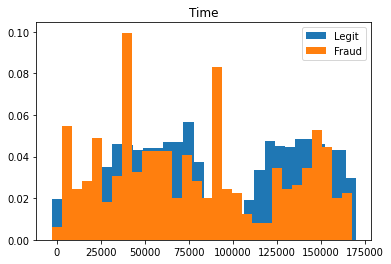

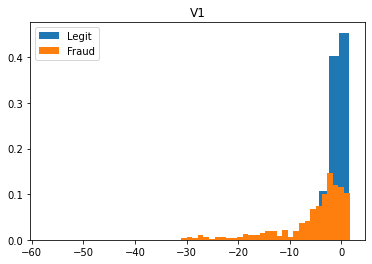

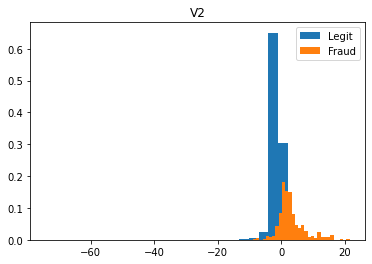

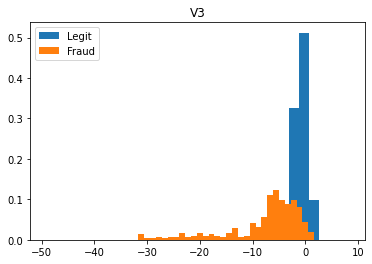

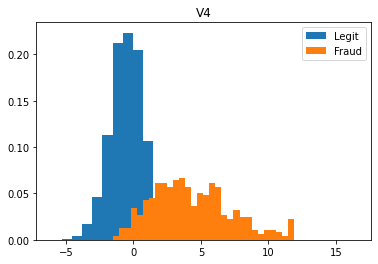

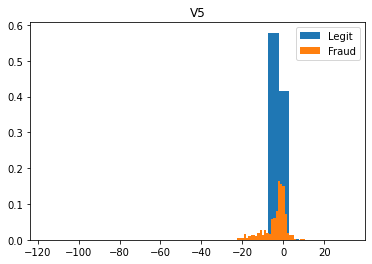

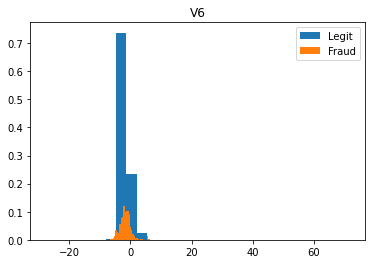

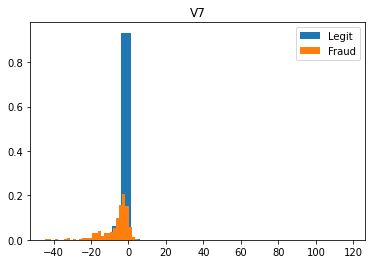

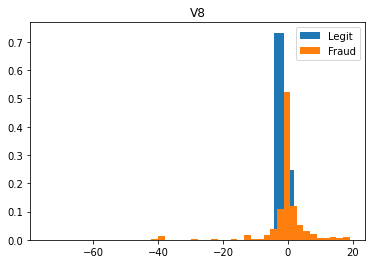

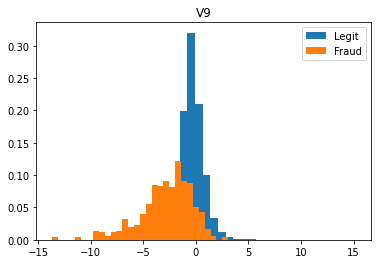

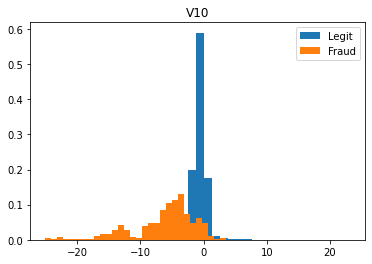

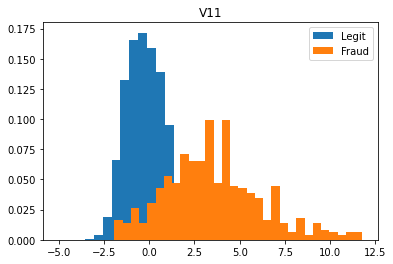

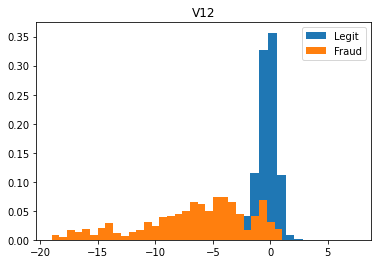

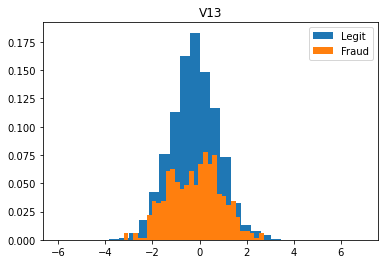

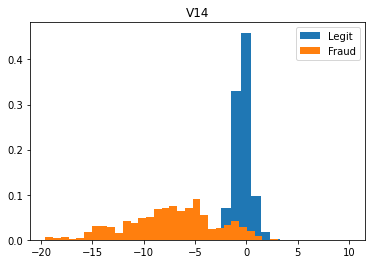

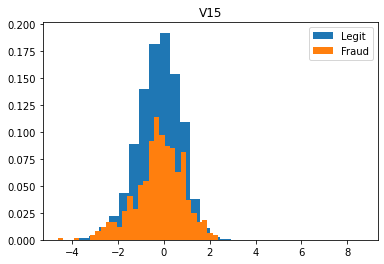

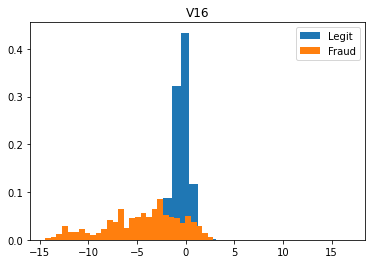

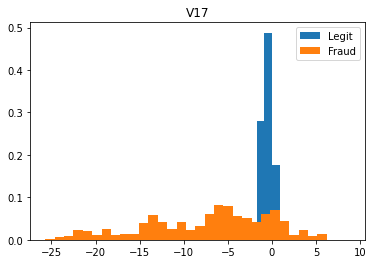

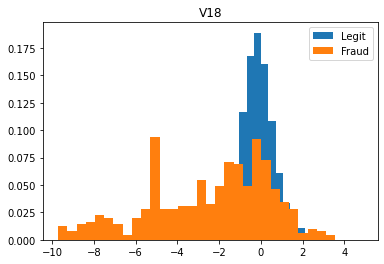

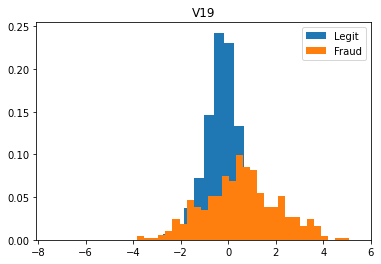

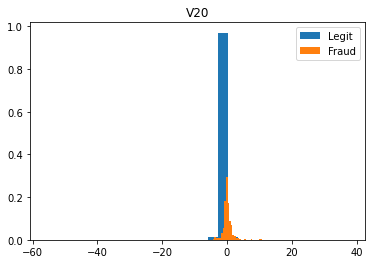

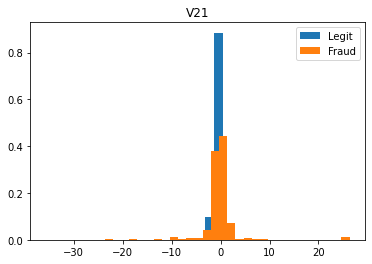

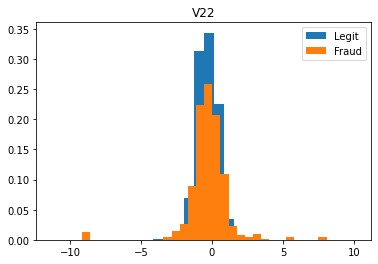

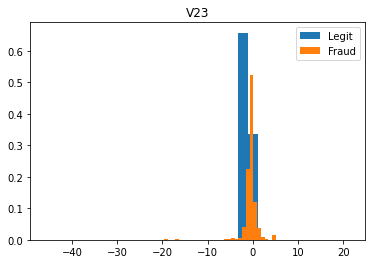

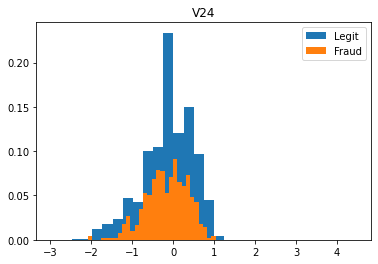

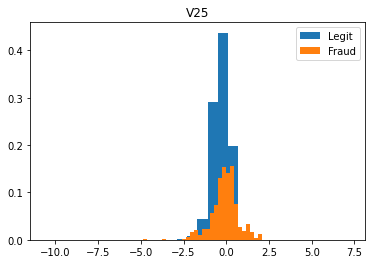

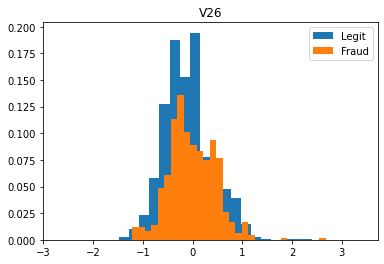

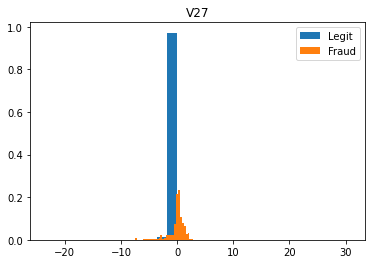

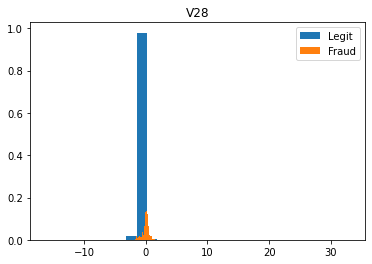

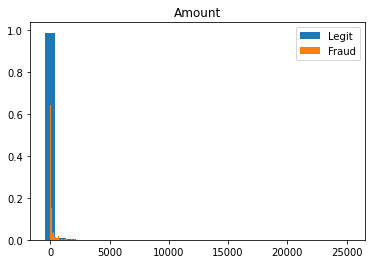

In [ ]:
for col in fraud.columns[0:-1]:
  hist_f = fraud.select(col).rdd.flatMap(lambda x: x).histogram(30)
  hist_l = legit.select(col).rdd.flatMap(lambda x: x).histogram(30)
  # Loading the Computed Histogram into a Pandas Dataframe for plotting
  fig = plt.figure()
  plt.title(col)
  plt.axis(True)
  plt.bar(hist_l[0][0:-1],hist_l[1]/np.sum(hist_l[1]), width=np.diff(hist_l[0]))
  plt.bar(hist_f[0][0:-1],hist_f[1]/np.sum(hist_f[1]), width=np.diff(hist_f[0]))
  plt.legend(["Legit","Fraud"])

  plt.show()

La differenza tra le due distribuzioni è meno evidente ad una analisi visiva di natura qualitativa, calcoliamo quindi la divergenza di Kullback-Leibler $D_{KL}(Fraud || Legit)$ per avere informazioni quantitative sulla differenza tra le distribuzioni.

Per farlo approssimiamo le distribuzioni continue con delle distribuzioni gaussiane, per le quali è possibile ottenere una forma analitica chiusa della divergenza a partire da semplici descrittori statistici:

 $$ D_{KL}(N(\mu_1,\sigma_1)||N(\mu_2,\sigma_2)) = log{\frac{\sigma_2}{\sigma_1}} +  \frac{\sigma_1^2 + (\mu_1 - \mu_2 )^2}{2\sigma_2^2} - \frac{1}{2} $$

Data la forma degli istogrammi visti precedentemente, si potrebbero ottenere risultati più precisi utilizzando una distribuzione gamma, ma il calcolo della divergenza risulta meno immediato.

Calcoliamo inoltre anche il Fisher score delle varie feature
$$ F = \frac{\sum_{j=1}^k p_j(\mu_j-\mu)^2}
            {\sum_{j=1}^k p_j\sigma_j^2} $$

In [ ]:
stats_f = fraud.describe().toPandas()
stats_l = legit.describe().toPandas()
stats_global = records.describe().toPandas()

p_f = float(stats_f.loc[1,"Time"]) / float(stats_global.loc[1,"Time"])
p_l = float(stats_l.loc[1,"Time"]) / float(stats_global.loc[1,"Time"])

import numpy as np

def fisher(m_1,s_1,p_1,m_2,s_2,p_2,m_3):
  m_1 = float(m_1)
  s_1 = float(s_1)
  m_2 = float(m_2)
  s_2 = float(s_2)
  m_3 = float(m_3)

  num = p_1*(m_1-m_3)**2  + p_2*(m_2-m_3)**2
  dem = p_1*s_1**2        + p_2*s_2**2

  return num/dem

def divergence_norm(m_1,s_1,m_2,s_2):
  m_1 = float(m_1)
  s_1 = float(s_1)
  m_2 = float(m_2)
  s_2 = float(s_2)

  k1 = np.log(s_2/s_1)
  k2 = ((s_1**2)+(m_1-m_2)**2)/(2*s_2**2)
  return k1+k2-0.5

for col in fraud.columns[0:-1]:
  m1 = float(stats_f.loc[1,col])
  s1 = float(stats_f.loc[2,col]) 
  m2 = float(stats_l.loc[1,col])
  s2 = float(stats_l.loc[2,col])
  m3 = float(stats_global.loc[1,col])

  print("Feature", col,":")
  print("        Divergenza:     ", divergence_norm(m1,s2,m2,s2))
  print("        Fisher:         ", fisher(m1,s2,p_f,m2,s2,p_l,m3))

Feature Time :
        Divergenza:      0.044033491431549
        Fisher:          0.04035996636503398
Feature V1 :
        Divergenza:      3.0678373649415893
        Fisher:          2.8119008699302093
Feature V2 :
        Divergenza:      2.461222251043964
        Fisher:          2.25589304957627
Feature V3 :
        Divergenza:      11.652571077565955
        Fisher:          10.68044712029745
Feature V4 :
        Divergenza:      5.286026115726935
        Fisher:          4.845035660346805
Feature V5 :
        Divergenza:      2.705838031424606
        Fisher:          2.480101586023274
Feature V6 :
        Divergenza:      0.5542121767551709
        Fisher:          0.5079766351869345
Feature V7 :
        Divergenza:      11.196828707555477
        Fisher:          10.26272537880581
Feature V8 :
        Divergenza:      0.12114724450427417
        Fisher:          0.1110404502220743
Feature V9 :
        Divergenza:      2.816675499879335
        Fisher:          2.58169236053118

Feature|      Divergenza           | Fisher score
-------|---------------------------|-------------------------
Time   |      0.044033491431549    |  0.04035996636503398
V1     |      3.0678373649415893   |  2.8119008699302093
V2     |      2.461222251043964    |  2.25589304957627
V3     |      11.652571077565955   |  10.68044712029745
V4     |      5.286026115726935    |  4.845035660346805
V5     |      2.705838031424606    |  2.480101586023274
V6     |      0.5542121767551709   |  0.5079766351869345
V7     |      11.196828707555477   |  10.26272537880581
V8     |      0.12114724450427417  |  0.1110404502220743
V9     |      2.816675499879335    |  2.5816923605311803
V10    |      14.829318777840216   |  13.592172404052853
V11    |      7.200782982367448    |  6.600052585474389
V12    |      21.968982256074      |  20.136204423115494
V13    |      0.00605726469184397  |  0.005551933114524093
V14    |      30.30824603478496    |  27.779759241863623
V15    |      0.00517455381454368  |  0.004742863014478271
V16    |      12.049868810653743   |  11.044600009905444
V17    |      39.69063486315946    |  36.37941566759858
V18    |      3.7203879009625993   |  3.410011917432181
V19    |      0.35278069659157374  |  0.32334971826621534
V20    |      0.11748832386214125  |  0.10768677761406935
V21    |      0.49732443422948736  |  0.4558347926876074
V22    |      0.00018909326131133  |  0.00017331802267466458
V23    |      0.00211015213641729  |  0.0019341112067686006
V24    |      0.01511134412563064  |  0.013850669588374605
V25    |      0.00317956108857930  |  0.0029143039631576565
V26    |      0.00575509507374927  |  0.00527497220985014
V27    |      0.0913092596542402   |  0.08369172029408732
V28    |      0.02644801644223948  |  0.024241572024557952
Amount |      0.00919695976440371  |  0.008429696912154396

Da questa analisi vediamo come le feature che, secondo la PCA, sono responsabili della maggior parte della variazione non sono necessariamente le migliori per differenziare le due classi. Come era ragionevole aspettarsi, inoltre, le feature con maggiore divergenza di Kullback-Leibler hanno anche maggiore Fisher score.

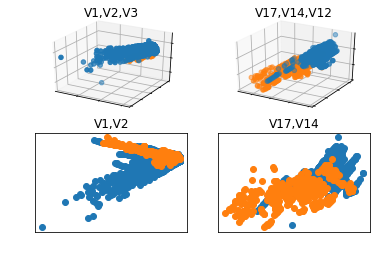

In [ ]:
legit_v1    =legit.select("V1").toPandas()
legit_v2    =legit.select("V2").toPandas()
legit_v3    =legit.select("V3").toPandas()

legit_v17 =legit.select("V17").toPandas()
legit_v14 =legit.select("V14").toPandas()
legit_v12 =legit.select("V12").toPandas()

fraud_v1    =fraud.select("V1").toPandas()
fraud_v2    =fraud.select("V2").toPandas()
fraud_v3    =fraud.select("V3").toPandas()

fraud_v17 =fraud.select("V17").toPandas()
fraud_v14 =fraud.select("V14").toPandas()
fraud_v12 =fraud.select("V12").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V1,V2,V3")
ax.scatter(legit_v1, legit_v2, legit_v3)
ax.scatter(fraud_v1, fraud_v2, fraud_v3)

ax = fig.add_subplot(2,2,3)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V1,V2")
ax.scatter(legit_v1, legit_v2)
ax.scatter(fraud_v1, fraud_v2)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V14,V12")
ax.scatter(legit_v17, legit_v14, legit_v12)
ax.scatter(fraud_v17, fraud_v14, fraud_v12)

ax = fig.add_subplot(2,2,4)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V14")
ax.scatter(legit_v17, legit_v14)
ax.scatter(fraud_v17, fraud_v14)

plt.show()

Anche visivamente è possibile notare che utilizzando le feature la cui distribuzione nelle due classi ha maggiore divergenza le due classi risultano meno "aderenti"

## Classification

Visto che le due classi sono fortemente sbilanciate, il classificatore verrebbe principalmente addestrato su campioni appartenenti alla classe delle transazioni legittime, introducendo un bias indesiderato: tutte le transazioni verrebbero classificate come legittime. 
Per questo motivo utilizziamo delle tecniche per mitigare il problema.

In [ ]:
# Definiamo una funzione per stampare l'area sotto la curva precision-recall e 
# la matrice di confusione per il training set.
from pyspark.ml.tuning import CrossValidator

def evaluate_model(cvModel, train, test, callable=True):
  evaluator = cvModel.getEvaluator()
  predictions = cvModel.transform(test)
  performance = cvModel.transform(train)
  summary = cvModel.bestModel.stages[2].summary() \
            if callable else cvModel.bestModel.stages[2].summary

  auprc = evaluator.evaluate(performance)
  print(f"Area Under PR Curve (train): {(100*auprc):05.2f}%")

  plt.figure(figsize=(5,5))
  plt.plot([0, 1], [0, 1], 'r--')
  plt.plot(summary.roc.select('FPR').collect(),
          summary.roc.select('TPR').collect())
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title("Precision-Recall curve")
  plt.show()

  print("Test set results:")
  auprc = evaluator.evaluate(predictions)
  print(f"Area Under PR Curve:  {(100*auprc):05.2f}%")

  predictions.createOrReplaceTempView('predictions')
  tp = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 1 AND
                    predictions.prediction == 1.0 """).collect()[0].c
  print(f"True positives:       {tp}")
  fp = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 0 AND
                    predictions.prediction == 1.0 """).collect()[0].c
  print(f"False positives:      {fp}")
  tn = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 0 AND
                    predictions.prediction == 0.0 """).collect()[0].c
  print(f"True negatives:       {tn}")
  fn = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 1 AND
                    predictions.prediction == 0.0 """).collect()[0].c
  print(f"False negatives:      {fn}")

  sn.heatmap([[tp, fp],[fn,tn]], annot=True, fmt='.3g', cbar=False)\
   .set_title("Confusion matrix");

  precision = (tp)/(tp+fp)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  recall = (tp)/(tp+fn)
  print(f"Precision:            {precision:1.3f}")
  print(f"Accuracy:             {accuracy:1.3f}")
  print(f"Recall:               {recall:1.3f}")
  print(f"F1:                   {(2*precision*recall)/(precision+recall):1.3f}")
  

In [ ]:
# L'evaluator sarà lo stesso per tutti i modelli
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("Class")\
                                           .setMetricName("areaUnderPR")

In [ ]:
# Necessary imports for all methods

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import StringIndexer

# The two classifiers
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier 

### Undersampling

Nel training set sottocampioniamo gli elementi appartenenti alla classe dominante per non introdurre bias sulla frequenza relativa delle classi.

In [ ]:
# Per ottenere train e test set tramite undersampling

def undersample_split(fraud, legit):
  train_f, test_f = fraud.randomSplit([0.8, 0.2])
  train_l, test_l = legit.randomSplit([0.8, 0.2])
  train_l = train_l.sample(False, 1.0*fraud.count()/legit.count()) \
      .limit (train_f.count())
  
  train       = train_f.union(train_l)
  test        = test_f.union(test_l)
  return (train, test)

train, test = undersample_split(fraud, legit)

#### Naive Bayes

Come baseline utilizziamo un classificatore Naive Bayes. Visto che le feature provengono da una PCA la loro covarianza sarà nulla, concordemente all'ipotesi del classificatore naive bayes che suppone feature indipententi tra loro. 

L'implementazione in spark supporta solamente Naive Bayes multinomiale, non adatto al nostro problema con variabili continue, utilizziamo quindi l'implementazione di sklearn. L'implementazione di sklearn prevende anche un addestramento parziale su un sottoinsieme dei dati per volta, è quindi utilizzabile anche nel caso in cui il dataset fosse troppo grande per entrare in memoria per intero.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

def evaluate_sklearn(clf, train, test, columns):
  train_labels = train.select("Class").toPandas().values.ravel()
  auprc = average_precision_score(train_labels,
              clf.predict(train.select(columns).toPandas()))
  print(f"Area Under PR Curve (train): {(100*auprc):05.2f}%")
  
  test_labels = test.select("Class").toPandas().values.ravel()
  test_pred   = clf.predict(test.select(columns).toPandas())

  print("Test set results:")
  print(f"Area Under PR Curve:  {(100*roc_auc_score(test_labels, test_pred)):05.2f}%")
  cm = confusion_matrix(test_labels, test_pred)
  
  tp=cm[1][1]
  fp=cm[0][1]
  tn=cm[0][0]
  fn=cm[1][0]
  
  sn.heatmap([[tp, fp],[fn,tn]], annot=True, fmt='.3g', cbar=False)\
      .set_title("Confusion matrix");
  
  precision = (tp)/(tp+fp)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  recall = (tp)/(tp+fn)
  print(f"Precision:            {precision:1.3f}")
  print(f"Accuracy:             {accuracy:1.3f}")
  print(f"Recall:               {recall:1.3f}")
  print(f"F1:                   {(2*precision*recall)/(precision+recall):1.3f}")

Area Under PR Curve (train): 81.99%
Test set results:
Area Under PR Curve:  79.75%
Precision:            0.127
Accuracy:             0.992
Recall:               0.602
F1:                   0.210


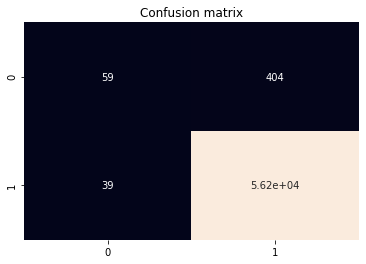

In [ ]:
train, test = undersample_split(fraud, legit)
train_labels = train.select("Class").toPandas().values.ravel()

clf = GaussianNB(priors=[0.9983,0.0017]).fit(train.select(train.columns).toPandas(), 
                       train_labels)
evaluate_sklearn(clf, train, test, train.columns)

#### Support vector machine 

Come secondo approccio proviamo ad utilizzare come classificatore una support vector machine lineare, normalizziamo le feature utilizzate per la classificazione

In [ ]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
linearSVC = LinearSVC().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)

pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                linearSVC,\
                                labelConverter])

In [ ]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(linearSVC.regParam, [0.1, 0.2, 0.5])\
                              .addGrid(linearSVC.maxIter, [20,50,100,200])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

Area Under PR Curve (train): 98.39%


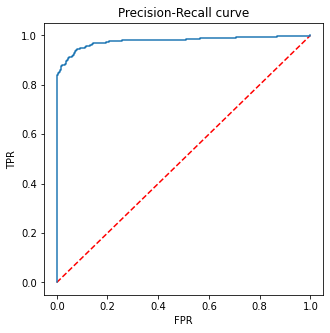

Test set results:
Area Under PR Curve:  62.62%
True positives:       83
False positives:      191
True negatives:       56507
False negatives:      12
Precision:            0.303
Accuracy:             0.996
Recall:               0.874
F1:                   0.450


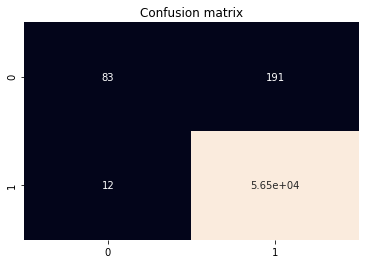

In [ ]:
cvModel_svm_us = cv.fit(train)

evaluate_model(cvModel_svm_us, train, test)
cvModel_svm_us.write().overwrite().save('svm_UF')

L'85% delle frodi viene correttamente identificato, però 2/3 delle transazioni classificate come frodi sono in realtà transazioni legittime. Un tasso di falsi positivi così alto porta a perdere fiducia nello strumento diagnostico.

In [ ]:
print("Best model hyperparameters")
print("Max Iterations:   ",cvModel_svm_us.bestModel.stages[2].getMaxIter())
print("Reg Parameter:    ",cvModel_svm_us.bestModel.stages[2].getRegParam())

Best model hyperparameters
Max Iterations:    200
Reg Parameter:     0.1


#### Random forest 

Confrontiamo il risultato precedente con una random forest, addestrata con gli stessi dati.

In [ ]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
randomForest = RandomForestClassifier().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)
pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                randomForest,\
                                labelConverter])


In [ ]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(randomForest.maxBins,[30, 41, 54])\
                              .addGrid(randomForest.maxDepth,[2,4,6])\
                              .addGrid(randomForest.impurity,["entropy","gini"])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

cvModel_random_forest_us = cv.fit(train)

Area Under PR Curve (train): 99.76%


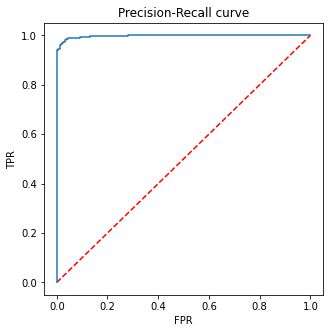

Test set results:
Area Under PR Curve:  63.68%
True positives:       98
False positives:      1692
True negatives:       55357
False negatives:      6
Precision:            0.055
Accuracy:             0.970
Recall:               0.942
F1:                   0.103


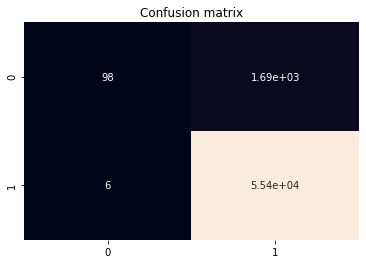

In [ ]:

evaluate_model(cvModel_random_forest_us, train, test, callable=False)
cvModel_random_forest_us.write().overwrite().save('random_forest_UF')

La random forest classifica correttamente molte più transazioni fraudolente, ma la precisione precipita.

In [ ]:
print("Best model hyperparameters")
print("Impurity:   ",cvModel_random_forest_us.bestModel.stages[2].getImpurity())
print("Max Bins:   ",cvModel_random_forest_us.bestModel.stages[2].getMaxBins())
print("Max Depth:  ",cvModel_random_forest_us.bestModel.stages[2].getMaxDepth())

Best model hyperparameters
Impurity:    gini
Max Bins:    41
Max Depth:   6


### Riduzione delle feature

I modelli precedenti, se addestrati con oversampling, non si comportano abbastanza bene, soprattutto la random forest. L'addestramento sta però avvenendo su un sottoinsieme molto piccolo dei dati sulle transazioni legittime, potremmo quindi non catturare delle caratteristiche importanti dei dati. Risulta allora opportuno provare un oversampling. 

L'addestramento con una porzione così grande del dataset con vettori di 30 feature però è una operazione molto pesante, ed è anche possibile che l'elevata dimensionalità riduca il potere di discriminazione dei modelli (curse of dimensionality). Effettuiamo quindi delle operazioni di selezione delle features.

#### Sfruttamento dei modelli addestrati precedentemente

Dai modelli appena addestrati è possibile ottenere informazioni riguardo l'importanza delle varie features.


##### **SVM**

Visto che le feature provengono da una PCA sono linearmente non correlate tra loro, inoltre le feature sono state scalate per ricadere tutte nell'intervallo $[0,1]$. I pesi appresi dalla SVM possono quindi fornire informazione su quali feature sono più rilevanti per la separazione delle due classi.

In [ ]:
cvModel_svm_us.bestModel.stages[2].coefficients

DenseVector([0.0632, -0.4207, 1.4625, -0.5842, 2.1455, 0.426, -0.7083, -0.5741, 0.7276, -0.6944, -0.8199, 1.831, -1.1688, -0.1381, -3.0533, 0.029, -0.6194, -0.5519, -0.3517, -0.1983, 0.6651, 3.027, 0.6381, 2.2021, -0.213, 0.5185, 0.1614, 0.9353, 0.8128, 0.8083])

Scaliamo il valore assoluto dei coefficienti per avere somma unitaria e li riportiamo nella tabella seguente 

Feature | Weight
-|-
  V21     |  0.1101
  V14     |  0.1014
  V11     |  0.0755
  V23     |  0.0732
  V4      |  0.0675
  V2      |  0.0605
  V10     |  0.0578
  V12     |  0.0402
  V22     |  0.0402
  Amount  |  0.0395
  V6      |  0.0375
  V8      |  0.0329
  V9      |  0.0319
  V28     |  0.0272
  V27     |  0.0258
  V7      |  0.0240
  V3      |  0.0238
  V16     |  0.0228
  V25     |  0.0223
  V17     |  0.0210
  V20     |  0.0198
  V1      |  0.0165
  V19     |  0.0064
  V5      |  0.0054
  V18     |  0.0039
  V15     |  0.0032
  V24     |  0.0030
  Time    |  0.0023
  V26     |  0.0017
  V13     |  0.0013


Le prime sette feature hanno più del 50% dell'importanza, e scartando le ultime 11 non si perde più del 10%.


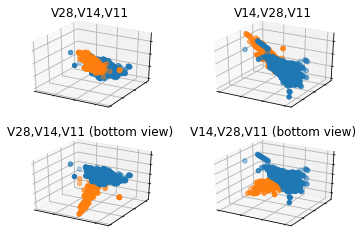

In [ ]:
legit_x    =legit.select("V21").toPandas()
legit_y    =legit.select("V14").toPandas()
legit_z    =legit.select("V11").toPandas()

fraud_x    =fraud.select("V21").toPandas()
fraud_y    =fraud.select("V14").toPandas()
fraud_z    =fraud.select("V11").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V28,V14,V11")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, fraud_z)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V28,V11")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, fraud_z)

ax = fig.add_subplot(2,2,3,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V28,V14,V11 (bottom view)")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, -fraud_z)

ax = fig.add_subplot(2,2,4,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V28,V11 (bottom view)")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, -fraud_z)

plt.show()

Osserviamo che considerando le sole tre features con i pesi maggiori è già possibile distinguere abbastanza nitidamente le due classi, meglio di quanto visto usando come features V1, V2, V3, e il che effettivamente risultano essere abbastanza in basso nella lista ed eccezione di V2.

##### **Random Forest**

La random forest non dava risultati molto incoraggianti, però visto che gli split sono effettuati in base all'entropia può essere interessante osservare quali feature sono state ritenute più importanti.

In [ ]:
cvModel_random_forest_us.bestModel.stages[2].featureImportances

SparseVector(30, {0: 0.0108, 1: 0.0028, 2: 0.0262, 3: 0.0202, 4: 0.1828, 5: 0.0046, 6: 0.006, 7: 0.0504, 8: 0.0068, 9: 0.009, 10: 0.1286, 11: 0.0183, 12: 0.0557, 13: 0.003, 14: 0.1918, 15: 0.0055, 16: 0.1001, 17: 0.0657, 18: 0.0077, 19: 0.0095, 20: 0.0106, 21: 0.0251, 22: 0.0041, 23: 0.0141, 24: 0.0061, 25: 0.0028, 26: 0.0081, 27: 0.0104, 28: 0.0065, 29: 0.0068})

Per comodità di visione si riportano i dati in output al comando precedente anche in formato tabellare.

Feature | Importance
-|-
  V10 |  0.3711 
  V12 |  0.1409 
  V17 |  0.0927 
  V14 |  0.0807 
  V11 |  0.0728 
  V7 |  0.0351 
  V4 |  0.0226 
  V9 |  0.0206 
  Amount |  0.0206 
  V8 |  0.0199 
  V18 |  0.0167 
  V1 |  0.0154 
  V3 |  0.0095 
  V20 |  0.0095 
  V16 |  0.0087 
  V26 |  0.006 
  V23 |  0.0069 
  V6 |  0.005 
  V19 |  0.0058 
  V13 |  0.0057 
  V15 |  0.0053 
  V27 |  0.004 
  V2 |  0.004 
  Time |  0.0045 
  V28 |  0.0039 
  V21 |  0.0038 
  V24 |  0.0029 
  V5 |  0.0024 
  V25 |  0.0016 
  V22 |  0.0015 



Le prime due features da sole hanno il 50% dell'importanza, e per arrivare al 90% bastano le prime 12

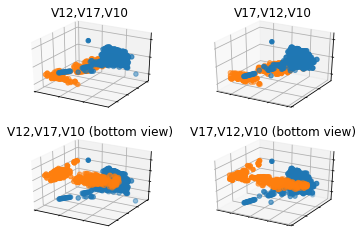

In [ ]:
legit_x    =legit.select("V12").toPandas()
legit_y    =legit.select("V17").toPandas()
legit_z    =legit.select("V10").toPandas()

fraud_x    =fraud.select("V12").toPandas()
fraud_y    =fraud.select("V17").toPandas()
fraud_z    =fraud.select("V10").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V12,V17,V10")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, fraud_z)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V12,V10")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, fraud_z)

ax = fig.add_subplot(2,2,3,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V12,V17,V10 (bottom view)")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, -fraud_z)

ax = fig.add_subplot(2,2,4,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V12,V10 (bottom view)")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, -fraud_z)

plt.show()

Ad una ispezione visiva le classi sembrano separate meglio di quanto non succedesse con la SVM, viene quindi da pensare che le prestazioni migliori siano dovute alla scarsità di campioni di transazioni legittime osservati, che ha portato ad attribuire alla classe di transazioni fraudolete aree più ampie del dovuto.



$D_{KL}$ | Fisher  |  RF     |   SVM     
---------|---------|---------|-----------
 V17     | V17     |  V10    |   V21      
 V14     | V14     |  V12    |   V14      
 V12     | V12     |  V17    |   V11      
 V10     | V10     |  V14    |   V23      
 V16     | V16     |  V11    |   V4       
 V3      |  V3     |  V7     |   V2        
 V7      |  V7     |  V4     |   V10       
 V11     | V11     |  V9     |   V12      
 V4      |  V4     |  Amount |   V22       
 V18     | V18     |  V8     |   Amount   
 V1      |  V1     |  V18    |   V6        
 V9      |  V9     |  V1     |   V8        
 V5      |  V5     |  V3     |   V9        
 V2      |  V2     |  V20    |   V28       
 V6      |  V6     |  V16    |   V27       
 V19     | V21     |  V26    |   V7       
 V8      |  V19    |  V23    |   V3         
 V21     | V8      |  V6     |   V16      
 V27     | V20     |  V19    |   V25       
 V20     | V27     |  V13    |   V17     
 Time    | Time    |  V15    |   V20     
 V28     | V28     |  V27    |   V1      
 V24     | V24     |  V2     |   V19     
 V23     | Amount  |  Time   |   V5      
 Amount  | V13     |  V28    |   V18     
 V22     | V26     |  V21    |   V15     
 V26     | V15     |  V24    |   V24     
 V13     | V25     |  V5     |   Time    
 V15     | V23     |  V25    |   V26     
 V25     | V22     |  V22    |   V13     

Scegliamo come feature da utilizzare per l'addestramento con versampling `[V14, V17, V10, V12, V11]`, ovvero le prime quattro feature in ordine di divergenza di Kullback-Leibler e Fisher, e `V11`. `V11` è all'ottavo posto nella colonne $D_{KL}$ e Fisher, ma è tra le prime cinque nelle altre due colonne, mentre `V16` è molto più giù.

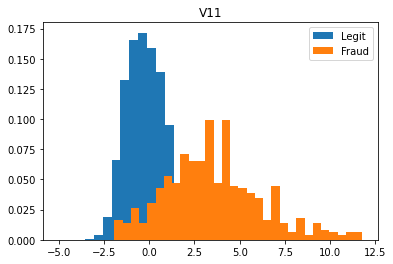

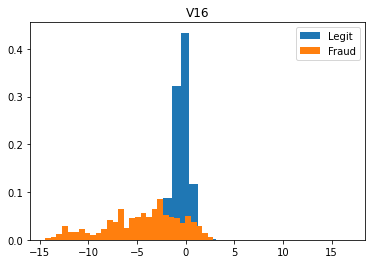

In [ ]:
for col in ["V11","V16"]:
  hist_f = fraud.select(col).rdd.flatMap(lambda x: x).histogram(30)
  hist_l = legit.select(col).rdd.flatMap(lambda x: x).histogram(30)
  # Loading the Computed Histogram into a Pandas Dataframe for plotting
  fig = plt.figure()
  plt.title(col)
  plt.axis(True)
  plt.bar(hist_l[0][0:-1],hist_l[1]/np.sum(hist_l[1]), width=np.diff(hist_l[0]))
  plt.bar(hist_f[0][0:-1],hist_f[1]/np.sum(hist_f[1]), width=np.diff(hist_f[0]))
  plt.legend(["Legit","Fraud"])
  
  plt.show()

In [ ]:
chosen_cols = ["V14", "V17", "V10", "V12", "V11"]

### Oversampling

Facendo undersampling non prendiamo in considerazione la maggior parte delle informazioni disponibili sulla classe dominante, portando a bassa capacità della rete di generalizzare, ricorriamo quindi ad oversampling.
Nel training set presentiamo più volte gli elementi appartenenti alla classe meno frequente per non introdurre bias sulla frequenza relativa delle classi.

Il test set viene estratto prima della duplicazione dei campioni per evitare di testare il classificatore sugli stessi dati su cui è stato testato.

In [ ]:
# Per ottenere train e test set tramite undersampling
import math
def oversample_split(fraud, legit):
  train_f, test_f = fraud.randomSplit([0.8, 0.2])
  train_l, test_l = legit.randomSplit([0.8, 0.2])

  a = range(math.ceil(train_l.count()/train_f.count()))
    # duplicate the minority rows
  oversampled_train_f = train_f.withColumn("dummy", explode(array([lit(x) for x in a])))\
    .drop('dummy')
  # The train test is balanced with 50/50 frauds and legit transactions
  # to avoid bias towards legit transactions
  train       = oversampled_train_f.union(train_l)
  # The test set has the same distribution of the original dataset
  test        = test_f.union(test_l)
  return (train, test)
  
train, test = oversample_split(fraud, legit)

#### Naive Bayes

Per prima cosa utilizziamo un classificatore del tipo Naïve Bayes sulle sole feature selezionate.  

Area Under PR Curve (train): 91.80%
Test set results:
Area Under PR Curve:  90.70%
Precision:            0.133
Accuracy:             0.991
Recall:               0.823
F1:                   0.229


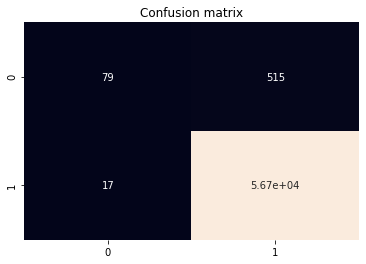

In [ ]:
train, test = oversample_split(fraud, legit)
train_labels = train.select("Class").toPandas().values.ravel()

clf = GaussianNB(priors=[0.9983,0.0017]).fit(train.select(chosen_cols).toPandas(), 
                       train_labels)
evaluate_sklearn(clf, train, test, chosen_cols)

Vediamo come le prestazioni sono sensibilmente migliorate rispetto allo stesso algoritmo addestrato con undersampling utilizzando tutte le features.

Per valutare l'impatto della scelta delle feature in questo miiglioramento di performance, addestriamo lo stesso classificatore sugli stessi dati, ma prendendo in considerazione le feature più importanti secondo la PCA.

Area Under PR Curve (train): 76.62%
Test set results:
Area Under PR Curve:  76.40%
Precision:            0.062
Accuracy:             0.986
Recall:               0.542
F1:                   0.112


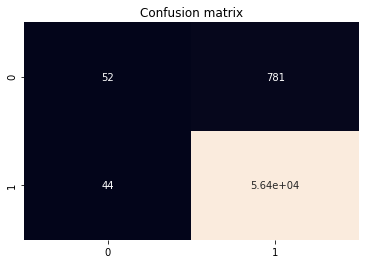

In [ ]:
clf_2 = GaussianNB(priors=[0.9983,0.0017]).fit(train.select(train.columns[1:6]).toPandas(), 
                       train_labels)
evaluate_sklearn(clf_2, train, test, train.columns[1:6])

Vediamo come una cattiva scelta delle feature causa invece un peggioramento su tutti gli indici di performance.

#### Support vector machine 

Come primo approccio proviamo ad utilizzare come classificatore una support vector machine lineare, inoltre sottocampioniamo le transazioni legittime per non avere un dataset sbilanciato.

In [ ]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(chosen_cols)\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
linearSVC = LinearSVC().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)

pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                linearSVC,\
                                labelConverter])

In [ ]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(linearSVC.regParam, [0.1, 0.2, 0.5])\
                              .addGrid(linearSVC.maxIter, [20,50,100,200])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

Area Under PR Curve (train): 96.97%


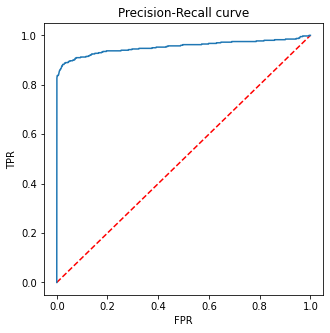

Test set results:
Area Under PR Curve:  75.83%
True positives:       79
False positives:      51
True negatives:       56862
False negatives:      14
Precision:            0.608
Accuracy:             0.999
Recall:               0.849
F1:                   0.709


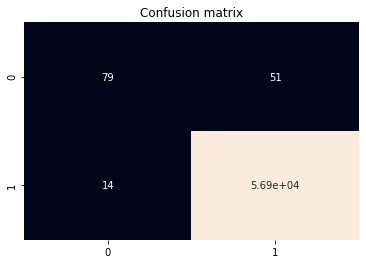

In [ ]:
cvModel_svm_os = cv.fit(train)

evaluate_model(cvModel_svm_os, train, test)

In [ ]:
cvModel_svm_os.write().overwrite().save('svm_OF')

Il classificatore basato su SVM mostra apprezzabili miglioramenti modificando la strategia di campionamento per il training set.

In [ ]:
print("Best model hyperparameters")
print("Max Iterations:   ",cvModel_svm_os.bestModel.stages[2].getMaxIter())
print("Reg Parameter:    ",cvModel_svm_os.bestModel.stages[2].getRegParam())

Best model hyperparameters
Max Iterations:    200
Reg Parameter:     0.1


#### Random forest 

Confrontiamo il risultato precedente con una random forest, addestrata con gli stessi dati.

In [ ]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(chosen_cols)\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
randomForest = RandomForestClassifier().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)
pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                randomForest,\
                                labelConverter])


In [ ]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(randomForest.maxBins,[30, 41, 54])\
                              .addGrid(randomForest.maxDepth,[4,6,8])\
                              .addGrid(randomForest.impurity,["entropy","gini"])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

cvModel_random_forest_os = cv.fit(train)

Area Under PR Curve (train): 99.71%


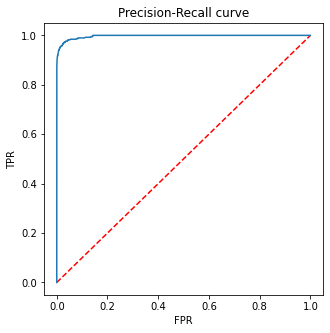

Test set results:
Area Under PR Curve:  82.57%
True positives:       93
False positives:      480
True negatives:       56812
False negatives:      15
Precision:            0.162
Accuracy:             0.991
Recall:               0.861
F1:                   0.273


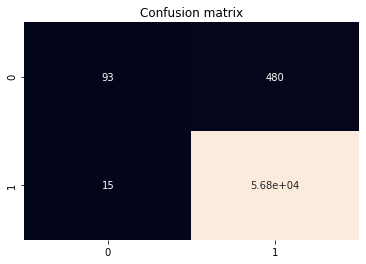

In [ ]:

evaluate_model(cvModel_random_forest_os, train, test, callable=False)
cvModel_random_forest_os.write().overwrite().save('random_forest_OF')

La random forest ha migliorato sensibilmente la precisione e l'area sotto la curva, ma resta comunque inferiore rispetto alla SVM.

In [ ]:
print("Best model hyperparameters")
print("Impurity:   ",cvModel_random_forest_os.bestModel.stages[2].getImpurity())
print("Max Bins:   ",cvModel_random_forest_os.bestModel.stages[2].getMaxBins())
print("Max Depth:  ",cvModel_random_forest_os.bestModel.stages[2].getMaxDepth())

Best model hyperparameters
Impurity:    entropy
Max Bins:    41
Max Depth:   8
